In [58]:
# --- Setup: fact & orders_valid laden ---
import pandas as pd
from pathlib import Path

BASE = Path.cwd().parent
PROC = BASE / "data" / "processed"
RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"

# Fakttabelle laden (nur die für die Aggregation nötigen Spalten)
fact = pd.read_parquet(PROC / "fact_order_items.parquet")[
    ["order_id", "customer_id", "seller_id"]
].drop_duplicates()

# Orders laden für den Zeitbezug
orders = pd.read_csv(
    RAW / "olist_orders_dataset.csv",
    parse_dates=["order_purchase_timestamp"]
)
orders_valid = orders[orders["order_status"] == "delivered"].copy()
orders_valid["order_month"] = orders_valid["order_purchase_timestamp"].dt.to_period("M")

# sanity checks
print("fact:", fact.shape, "orders_valid:", orders_valid.shape)
assert {"order_id","customer_id","seller_id"}.issubset(fact.columns)


fact: (99542, 3) orders_valid: (96478, 9)


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Pfade
BASE = Path.cwd().parent
RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"

# Orders laden
orders = pd.read_csv(
    RAW / "olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ]
)

# Nur gelieferte Bestellungen verwenden
orders_valid = orders[orders["order_status"] == "delivered"].copy()

print("Orders valid:", orders_valid.shape)


Orders valid: (96478, 8)


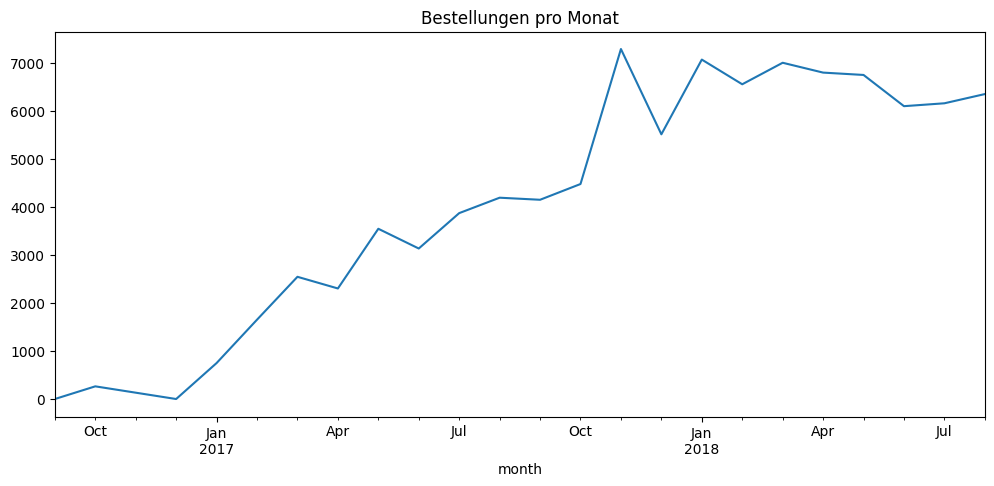

In [60]:
orders_valid["month"] = orders_valid["order_purchase_timestamp"].dt.to_period("M")
orders_valid["weekday"] = orders_valid["order_purchase_timestamp"].dt.day_name()
orders_valid["hour"] = orders_valid["order_purchase_timestamp"].dt.hour

orders_valid.groupby("month")["order_id"].nunique().plot(kind="line", figsize=(12,5), title="Bestellungen pro Monat")
plt.show()


In [61]:
# Sicherstellen, dass order_date/ timestamp korrekt formatiert ist
orders_valid["order_month"] = orders_valid["order_purchase_timestamp"].dt.to_period("M")

# aktive Kunden & Seller (unique IDs pro Monat)
monthly_activity = (
    fact.merge(orders_valid[["order_id", "order_month"]], on="order_id", how="left")
        .groupby("order_month")
        .agg(
            active_customers=("customer_id", "nunique"),
            active_sellers=("seller_id", "nunique"),
            orders=("order_id", "nunique")
        )
        .reset_index()
)

monthly_activity["order_month"] = monthly_activity["order_month"].astype(str)
monthly_activity.head()


,order_month,active_customers,active_sellers,orders
0,2016-09,1,1,1
1,2016-10,265,128,265
2,2016-12,1,1,1
3,2017-01,750,219,750
4,2017-02,1653,402,1653


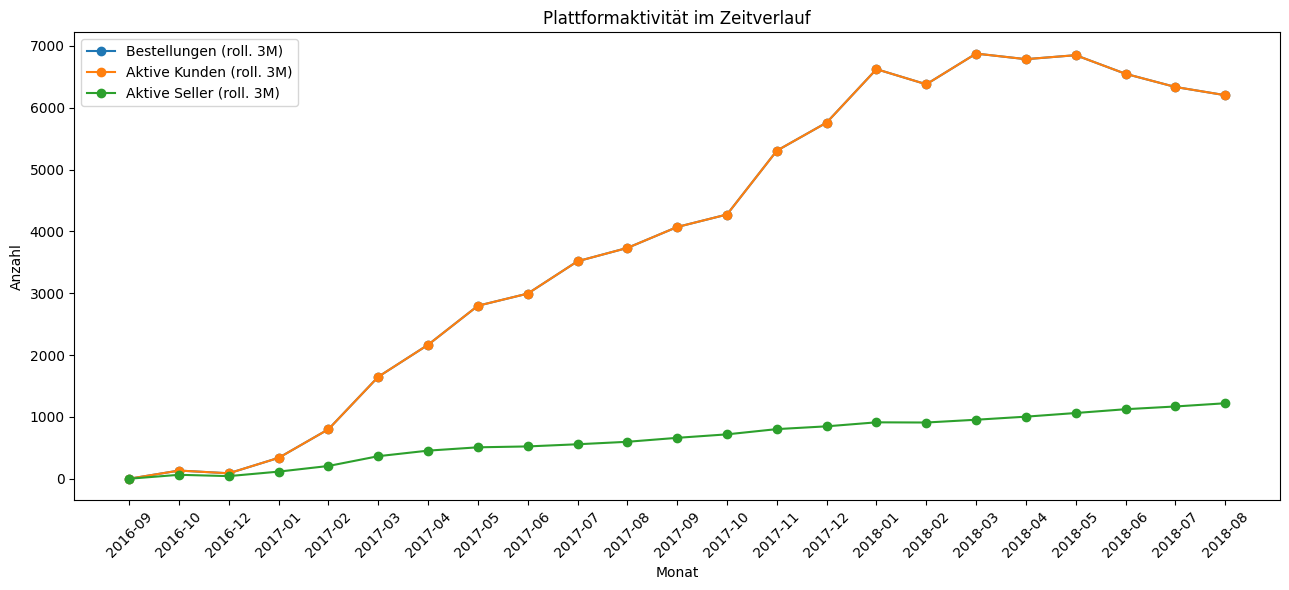

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Falls noch nicht geschehen: monthly_activity liegt schon vor
# (Spalten: order_month [str], orders, active_customers, active_sellers)

# Umsatz je Monat (optional – nur wenn in fact vorhanden)
if "item_revenue_brl" in fact.columns:
    monthly_rev = (
        fact.merge(orders_valid[["order_id","order_month"]], on="order_id", how="left")
            .groupby("order_month")["item_revenue_brl"].sum()
            .reset_index(name="umsatz_brl")
    )
    monthly_plot = monthly_activity.merge(monthly_rev, on="order_month", how="left")
else:
    monthly_plot = monthly_activity.copy()
    monthly_plot["umsatz_brl"] = pd.NA  # Platzhalter

# 3-Monats-Glättung (optional, hilft bei Interpretation)
for col in ["orders","active_customers","active_sellers"]:
    monthly_plot[f"{col}_roll3"] = (
        pd.Series(monthly_plot[col]).rolling(3, min_periods=1).mean()
    )

fig, ax1 = plt.subplots(figsize=(13,6))

# Linien: Orders, aktive Kunden, aktive Seller (geglättet + Punkte)
ax1.plot(monthly_plot["order_month"], monthly_plot["orders_roll3"], label="Bestellungen (roll. 3M)", marker="o")
ax1.plot(monthly_plot["order_month"], monthly_plot["active_customers_roll3"], label="Aktive Kunden (roll. 3M)", marker="o")
ax1.plot(monthly_plot["order_month"], monthly_plot["active_sellers_roll3"], label="Aktive Seller (roll. 3M)", marker="o")

ax1.set_xlabel("Monat")
ax1.set_ylabel("Anzahl")
ax1.tick_params(axis="x", rotation=45)

# Rechte Achse: Umsatz als (halbtransparente) Balken – falls vorhanden
if monthly_plot["umsatz_brl"].notna().any():
    ax2 = ax1.twinx()
    ax2.bar(monthly_plot["order_month"], monthly_plot["umsatz_brl"] / 1e6, alpha=0.25, label="Umsatz (Mio. BRL)")
    ax2.set_ylabel("Umsatz (Mio. BRL)")

# Gemeinsame Legende
handles, labels = ax1.get_legend_handles_labels()
if "ax2" in locals():
    h2, l2 = ax2.get_legend_handles_labels()
    handles += h2; labels += l2
ax1.legend(handles, labels, loc="upper left")

plt.title("Plattformaktivität im Zeitverlauf")
plt.tight_layout()
plt.show()
